<div style="text-align: center;">
<img src="https://assets-global.website-files.com/62b9d45fb3f64842a96c9686/62d84db4aeb2f6552f3a2f78_Quantinuum%20Logo__horizontal%20blue.svg" width="200" height="200" /></div>


# A high energy physics (HEP) application on Quantinuum H-series devices

```
High-energy physicists have quickly identified problems of importance to our understanding of nature at the most fundamental level, from tiniest distances to cosmological extents, that are intractable with classical computers but may benefit from quantum advantage.
```

from `Quantum Simulation for High Energy Physics` by Bauer et al. [(PRX Quantum 4, 027001)](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.4.027001).


## Introduction

Lattice gauge theory (LGT) is a vital computational tool in quantum field theory, enabling the acquisition of rigorous results without relying on perturbation theory. It's particularly significant in the context of quantum chromodynamics (QCD), where lattice computations have been instrumental in uncovering new properties of known hadrons, evaluating the likelihood of undiscovered hadrons, and providing critical insights for the search for new physics beyond the standard model.

Typically, LGT studies are conducted in Euclidean spacetime, where time is treated as an imaginary component. This approach is effective for many observables, but it limits the ability to analyze real-time dynamics. However, a Hamiltonian formulation in real-time could overcome this limitation, given adequate computing resources. This is where the potential of future quantum computers becomes particularly intriguing. Quantum computers could handle and evolve quantum states far beyond the capabilities of classical computers, thus offering a promising avenue for exploring real-time dynamics within LGT.

The paper [Self-mitigating Trotter circuits for SU(2) lattice gauge theory on a quantum computer](http://arxiv.org/abs/2205.09247) by Rahman, Lewis, Mendicelli, and Powell implements the time evolution of a simplified SU(2) lattice gauge theory in Minkowski spacetime using quantum computers, showcasing excitations traveling across a one-dimensional lattice. While the theoretical foundations laid out in the paper are robust, practical implementation on contemporary quantum hardware requires specialized techniques and considerations. 

This tutorial will implement some of the methods described in this paper on the Quantinuum H-Series device utilizing TKET and its extensions.

1. We detail the process of defining the SU(2) 2-Plaquette (two-qubit) Model Hamiltonian
2. We set up quantum circuits employing Trotterization to simulate the quantum dynamics of the system
3. We simulate the ideal execution of a quantum circuit using a statevector simulator for one Trotter step
4. We execute the circuit for two Trotter steps on the Quantinuum H1-1 emulator
5. We demonstrate an example of symbolic circuit construction.
6. We implement the SU(2) 5-Plaquette (five-qubit) Model Hamiltonian using the `Qiskit` library and showcase the interplay with H-series devices


## Setup

This notebook was generated using `pytket=1.27.0`, `pytket-quantinuum=0.33.0`, and `pytket-qiskit=0.53.0`. 

First, we import the libraries and modules we will use:

 - `Pauli` utilities and `QubitPauliOperator` are used for Hamiltonian representation.
 - `Circuit` utilities from `pytket` are used for constructing and analyzing quantum circuits.
 - Additional utilities are used for generating term sequences and gate statistics.
 - Standard libraries are used for numerical operations and visualization.

In [1]:
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils import QubitPauliOperator
from pytket.circuit import Circuit, Qubit, CircBox
from pytket.utils import gen_term_sequence_circuit
from pytket.utils.stats import gate_counts
from pytket import OpType
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

In [2]:
# Uncomment to verify installation of pytket extensions: pytket-quantinuum and pytket-qiskit.
# %pip show pytket pytket-quantinuum pytket-qiskit

*Note:* Plotting circuits requires an internet connection. An alternative for displaying circuits is the `pytket-offline-display` package for rendering circuits offline with no internet connection, for details see [here](https://github.com/CQCL/pytket-offline-renderer).

## SU(2) 2-Plaquette Model Hamiltonian

The SU(2) 2-plaquette model offers a streamlined representation of lattice gauge theories.

![Plaquette System with J=1/2](figures/j12_plaquettes.png)

The figure above shows the possible quantum states for a chain of 2 plaquettes, which can be considered an example of a 1+1D SU(2) lattice gauge theory. The gauge fields on the links are truncated in the electric basis to $j_{\rm max}=1/2$, and they can only have 2 possible values. When imposing the gauge symmetry constraint there are only 4 possible states for this quantum system: the links represented with a dashed line are in the lower state, and the links in bold are in the upper state. We can match those states to qubits, using one qubit for each plaquette:

![Plaqutte quantum states on qubits](figures/states.png)

Here we show the 2-qubit Hamiltonian for the SU(2) 2-plaquette model:

![Hamiltonian of the 2-Plaquette Model](figures/hamiltonian.png)

- The matrix form represents the action of the Hamiltonian on a 2-qubit system (with 4 total states)
- The expanded form shows the Hamiltonian in terms of tensor products of Pauli matrices, providing insight into the system's dynamics and interactions (parameterized by `x`)


This Hamiltonian encapsulates the dynamics of the system and serves as the foundation for subsequent quantum simulations.
Specifically, the terms associated with Pauli $Z$ matrices, like $Z_0$ and $Z_1$, are diagonal and capture the energies of the links: they come from the _electric term_ of the Hamiltonian.
The terms involving the Pauli $X$ matrices, such as $X_0$ and $X_1$, are off diagonal and represent the interactions of the links around the plaquette: they come from the _magnetic term_ of the Hamiltonian.


This Hamiltonian provides a framework for analyzing and simulating the dynamics of the SU(2) 2-plaquette model, making it a cornerstone for the quantum simulations presented in the paper and this notebook.

Having access to the Hamiltonian lets us explore how _excitations_ on one side of the system _propagate_ to the opposite side and oscillate, like in the figure below

![Excitations traveling across the lattice](figures/oscillations.png)

## 1. Implementation of the SU(2) 2-Plaquette Model Hamiltonian

The Hamiltonian for the SU(2) 2-plaquette model is implemented in `pytket` in this notebook using the `QubitPauliOperator` to write the operator on qubits and `QubitPauliString` to represent the individual Pauli string terms. Here we use $x = 2$. Note that it is always possible to write the Hamiltonian as a linear combination of Pauli strings (if one has access to the Hamiltonian in matrix form, it can be decomposed into Pauli operators e.g. following [the method in this paper](https://arxiv.org/html/2310.13421v3)).

In [2]:
hamiltonian = QubitPauliOperator(
    {
        QubitPauliString([], []): +7 * 3 / 8,
        QubitPauliString([Qubit(0)], [Pauli.Z]): -3 * 3 / 8,
        QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Z, Pauli.Z]): -3 / 8,
        QubitPauliString([Qubit(1)], [Pauli.Z]): -3 * 3 / 8,
        QubitPauliString([Qubit(0)], [Pauli.X]): -3,
        QubitPauliString([Qubit(0), Qubit(1)], [Pauli.X, Pauli.Z]): -1,
        QubitPauliString([Qubit(1)], [Pauli.X]): -3,
        QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Z, Pauli.X]): -1,
    }
)

We can display the `QubitPauliOperator` representation of the Hamiltonian:

In [3]:
print(hamiltonian)

{(): 2.62500000000000, (Zq[0]): -1.12500000000000, (Zq[0], Zq[1]): -0.375000000000000, (Zq[1]): -1.12500000000000, (Xq[0]): -3, (Xq[0], Zq[1]): -1, (Xq[1]): -3, (Zq[0], Xq[1]): -1}


You can also visualize the non-zero elements of the Hamiltonian matrix using a `spy` plot from the `matplotlib` library , shedding light on its non-zero components and overall structure:

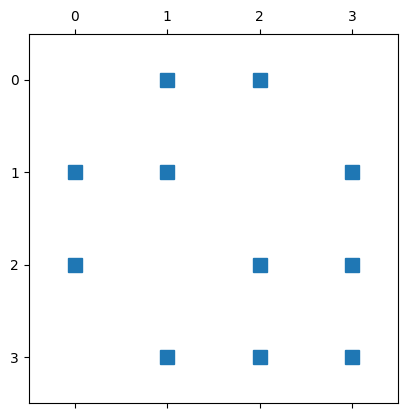

In [4]:
plt.spy(hamiltonian.to_sparse_matrix())

### Matrix Formulation

We can also convert the Hamiltonian `QubitPauliOperator` representation to a dense matrix and extract the Hamiltonian matrix elements. This transformation caters to computational tasks and subsequent quantum simulations (but it would not be scalable, since the memory required to represent all the elements is exponential in the number of qubits)

In [5]:
hm = hamiltonian.to_sparse_matrix(2).todense()
hm.real

matrix([[ 0. , -4. , -4. ,  0. ],
        [-4. ,  3. ,  0. , -2. ],
        [-4. ,  0. ,  3. , -2. ],
        [ 0. , -2. , -2. ,  4.5]])

### Time Evolution Operator

To simulate the time evolution of the quantum system, we compute the matrix exponential of the Hamiltonian matrix. This process represents how the quantum state evolves over a specific time interval. For instance, a factor like $0.1$ can be interpreted as a discrete time step in the system's evolution.

Let us first use the `expm` function to calculate the matrix exponential of the Hamiltonian for a time step of $0.1$.
The time evolution operator  $U(t)$ is expressed as:

$$
U(t) = e^{-i H t}
$$

For a time step of $0.1$, this operator becomes:

$$
U(0.1) = e^{-i H \times 0.1}
$$

This calculated operator, `exp_hm`, will then be applied to simulate the quantum state's evolution over the time step.

In [6]:
# Compute the matrix exponential of the Hamiltonian for the time step of 0.1
exp_hm = expm(-1j * hm * 0.1)
exp_hm

array([[ 0.84639558+0.0152074j ,  0.05508436+0.36836211j,
         0.05508436+0.36836211j, -0.07461882+0.01911594j],
       [ 0.05508436+0.36836211j,  0.8615547 -0.27351321j,
        -0.09378179+0.022007j  ,  0.06951527+0.17342834j],
       [ 0.05508436+0.36836211j, -0.09378179+0.022007j  ,
         0.8615547 -0.27351321j,  0.06951527+0.17342834j],
       [-0.07461882+0.01911594j,  0.06951527+0.17342834j,
         0.06951527+0.17342834j,  0.8648741 -0.41980935j]])

### Circuit Construction & Visualization

The next step is to represent this unitary operator as a quantum circuit.
This allows for direct simulations or runs on quantum hardware or simulators.
The `pytket` library provides tools to seamlessly achieve this.
By wrapping our time evolution operator in a 2-qubit unitary box `Unitary2qBox`, we can then incorporate it into a quantum circuit, setting the stage for subsequent quantum simulations or analyses.

In [7]:
# Creating a 2-qubit unitary box that represents the time evolution operator:
from pytket.circuit import Unitary2qBox

u2box = Unitary2qBox(exp_hm)

# Initializing a 2-qubit circuit and embedding the time evolution operator into it:
circ = Circuit(2)
circ.add_unitary2qbox(u2box, 0, 1)

[Unitary2qBox q[0], q[1]; ]

Retrieving the unitary matrix representation of the quantum circuit:

In [8]:
circ.get_unitary()

array([[ 0.84639558+0.0152074j ,  0.05508436+0.36836211j,
         0.05508436+0.36836211j, -0.07461882+0.01911594j],
       [ 0.05508436+0.36836211j,  0.8615547 -0.27351321j,
        -0.09378179+0.022007j  ,  0.06951527+0.17342834j],
       [ 0.05508436+0.36836211j, -0.09378179+0.022007j  ,
         0.8615547 -0.27351321j,  0.06951527+0.17342834j],
       [-0.07461882+0.01911594j,  0.06951527+0.17342834j,
         0.06951527+0.17342834j,  0.8648741 -0.41980935j]])

And obtaining the resulting quantum state after applying the circuit (from a default $|0 \rangle $ initial state):

In [9]:
circ.get_statevector()

array([ 0.84639558+0.0152074j ,  0.05508436+0.36836211j,
        0.05508436+0.36836211j, -0.07461882+0.01911594j])

### Decomposition

Recognizing the constraints of real quantum hardware, the constructed circuit is decomposed into a set of elementary gates, ensuring its adaptability and compatibility. Specifically, in quantum circuit design, 'boxed' operations encapsulate complex actions. To standardize our circuit for broader applications, we'll replace these boxed operations with sequences of elementary gates using pytket's `DecomposeBoxes`.

In [10]:
# Importing the necessary tool for gate decomposition:
from pytket.passes import DecomposeBoxes

# Decomposing custom gates in the circuit to ensure compatibility with quantum hardware:
DecomposeBoxes().apply(circ)

True

We can also visualize the quantum circuit using `pytket`'s rendering tool for Jupyter:

In [11]:
from pytket.circuit.display import render_circuit_jupyter as draw

draw(circ)

### Gate Analysis

The quantum circuit, post-decomposition, is dissected to provide a breakdown of its comprising gate types. This analysis gives valuable insights into the circuit's intricacy and underlying structure.

Insights into the composition and complexity of our circuit can be obtained with the following command:

In [12]:
gate_counts(circ)

Counter({<OpType.TK1: 43>: 4,
         <OpType.X: 23>: 2,
         <OpType.Z: 22>: 2,
         <OpType.Y: 24>: 2,
         <OpType.TK2: 44>: 1})

The breakdown of gate occurrences in our quantum circuit is as follows:

- `TK1` gates: 4
- `X` gates: 2
- `TK2` gates: 1
- `Z` gates: 2
- `Y` gates: 2

This summary serve as a valuable reference when we delve into the topics of recompilation and optimization for execution on H-series devices.

*Note:* See [pytket.circuit.OpType](https://cqcl.github.io/tket/pytket/api/optype.html#pytket-circuit-optype) for the mathematical descriptions of `TK1` and `TK2` gates.

### Time evolution circuits

The unitary operator, $e^{-iHt}$, needs to be discretized for simulation on a quantum computer because of the non-commuting nature of the terms in the Hamiltonian i.e. $e^{A+B} \ne e^A e^B$. This is where the Trotter-Suzuki approximation comes in handy, allowing us to approximate the time evolution operator $e^{-i H t}$.

$$
e^{-i H t}= e^{-it \sum_j H_j } = e^{-i\left(\frac{3}{8}\left(7-3 Z_0-Z_0 Z_1-3 Z_1\right)-\frac{x}{2}\left(3+Z_1\right) X_0-\frac{x}{2}\left(3+Z_0\right) X_1\right) t}
$$

### First-Order Trotter Step

In the first-order Trotter step, the time evolution operator is approximated by 

$$
e^{-i H t} \approx \left(\prod_j e^{-i H_j \delta t} \right)^{N_t}
$$

where $\delta t = \frac{t}{N_t}$. Here, $ N_t $ represents the number of Trotter steps, which is a parameter that determines the granularity of the time evolution approximation. A higher value of $ N_t $ leads to a finer approximation of the time evolution operator.


In [13]:
# Setting the maximum time for the simulation
t_max = 1

# Defining the number of Trotter steps for the approximation
n_trotter_steps = 10

# Calculating the time step for each Trotter step
time_step = t_max / n_trotter_steps

# Creating a time line from 0 to t_max with equal intervals for each Trotter step
time_line = np.linspace(0, t_max, n_trotter_steps + 1)

# Printing the calculated time step
print(f"Time step: {time_step}")

# Multiplying the Hamiltonian by the time step to get a slice of the Hamiltonian for each Trotter step
hamiltonian_slice = hamiltonian * time_step

Time step: 0.1


In [14]:
print(hamiltonian_slice)

{(): 0.262500000000000, (Zq[0]): -0.112500000000000, (Zq[0], Zq[1]): -0.0375000000000000, (Zq[1]): -0.112500000000000, (Xq[0]): -0.300000000000000, (Xq[0], Zq[1]): -0.100000000000000, (Xq[1]): -0.300000000000000, (Zq[0], Xq[1]): -0.100000000000000}


### Constructing the Quantum Circuit for a Single Trotter Step

After calculating the Hamiltonian slice for a single time step, we proceed to construct the quantum circuit that simulates this evolution. We use a utility `gen_term_sequence_circuit` which builds a circuit for us starting from the Hamiltonian we want in the exponent of a single Trotter step, and the initial reference state we want to start from. The default behavior of the function is to split the Pauli string in the Hamiltonian into sets of commuting operators. [Documentation page](https://cqcl.github.io/tket/pytket/api/utils.html#pytket.utils.gen_term_sequence_circuit)


In [15]:
# initializing a quantum circuit with two qubits
initial_state = Circuit(2)

# generate the circuit for the Trotter step
trotter_step_circ = gen_term_sequence_circuit(hamiltonian_slice, initial_state)

# visualize the circuit
draw(trotter_step_circ)

The circuit for a single Trotter step is composed of several `CircBox` components. The `get_commands()` method can be used to explore the composition of the circuit.

For a more detailed analysis, we use the `DecomposeBoxes` pass from `pytket.passes`. This pass decomposes the circuit into fundamental quantum gates, allowing us to see the basic operations that constitute the Trotter step.

For one Trotter step: 

In [19]:
test_circuit = trotter_step_circ.copy()
DecomposeBoxes().apply(test_circuit)
draw(test_circuit)

and we can count the total number of gates

In [20]:
gate_counts(test_circuit)

Counter({<OpType.H: 33>: 8, <OpType.Rz: 36>: 7, <OpType.CX: 45>: 6})

or look at specific statistics of the circuit

In [22]:
print(f"Number of gates = {test_circuit.n_gates}")
print(f"Circuit depth = {test_circuit.depth()}")
print(f"Number of single-qubit gates = {test_circuit.n_1qb_gates()}")
print(f"Number of two-qubit gates = {test_circuit.n_2qb_gates()}")
print(f"Number of CX gates = {test_circuit.n_gates_of_type(OpType.CX)}")

Number of gates = 21
Circuit depth = 19
Number of single-qubit gates = 15
Number of two-qubit gates = 6
Number of CX gates = 6


## 2. Noiseless emulation of a circuit for one Trotter step

After getting a circuit, we can run a noiseless statevector simulation.
Thanks to Quantinuum Nexus and its ability to target different simulators and hardware providers, we can choose among different options.
Here we choose to target the Quantinuum H-series emulator for the H1-1 machine.
Quantinuum H-Series emulators model the physical and noise parameters of H-Series quantum computers.
The emulators provide a way to turn the noise model off, while still modeling the physical properties of the device, such as ion transport. 

In [23]:
from pytket.extensions.nexus import Nexus, NexusBackend, QuantinuumConfig


h_config = QuantinuumConfig(device_name="H1-Emulator")  # Nexus-hosted emulator for H1-1 

hep_nexus_project = Nexus().new_project(name="HEP Project")

h_backend = NexusBackend(
    backend_config=h_config,
    project=hep_nexus_project,
)

The Trotter step circuit can be enclosed in a `CircBox` and added to any circuit (this way we can add many steps in a sequence).

In [26]:
trotter_step_box = CircBox(trotter_step_circ)

# define circuit for one Trotter step: start with an empty circuit
circ = Circuit(len(hamiltonian_slice.all_qubits), name="Circuit One Step")
# and add the CircBox
circ.add_gate(trotter_step_box, circ.qubits)

draw(circ)

When we compile the circuit for the backend, the `CircBox` nested boxes get decomposed into native gates. Each backend in `pytket` has a list of default _passes_ that are applied to it. They can be applied by calling `backend.get_compiled_circuit()` with different `optimisation_level` arguments ([here](https://cqcl.github.io/pytket-quantinuum/api/index.html#default-compilation) some default values). Here we use the default `optimisation_level`, which is 2.

*Note:* The measurement operations from the `MeasurementSetup` object are appended to the numerical circuit. Once this step is complete, the circuit is ready for submission.

In [27]:
circ_compiled = h_backend.get_compiled_circuit(circ.measure_all())

draw(circ_compiled)

Before submitting to the emulator, the total cost of running the set of circuits in H-System Quantum Credits (HQCs) can be checked beforehand.

In [28]:
n_shots = 100
cost = h_backend.cost(circ_compiled, n_shots=n_shots, syntax_checker="H1-1SC")
print("Cost of experiment in HQCs:", cost)

Cost of experiment in HQCs: 5.92


We submit the circuit to the Quantinuum H1-1 Emulator and make the emulation noiseless by passing the option `noisy_simulation=False`.

In [29]:
handle = h_backend.process_circuit(
    circ_compiled, n_shots=n_shots, noisy_simulation=False
)

Optionally we can save the handle of the jobs to a file for future retrieval.

In [31]:
with open("handle_H1-Emulator_one_step_circuit.txt","w") as f:
    print(handle, file=f)

Let's try reading the handle from the file. We need to import the class `ResultHandle` for this to work.

In [ ]:
from pytket.backends import ResultHandle

with open("handle_H1-Emulator_one_step_circuit.txt", "r") as f:
    handle_str = f.read()

handle = ResultHandle.from_str(handle_str)

The status of the job on the emulator can be queried as follows:

In [37]:
circuit_status = h_backend.circuit_status(handle)
print(circuit_status.status)

StatusEnum.COMPLETED


And once completed, results can be collected in a `BackendResult` object (this object has some handy methods to collect counts, shots, probabilities of bitstrings, etc...)

In [38]:
result = h_backend.get_result(handle)
result.get_counts()

Counter({(0, 0): 39, (1, 0): 36, (0, 1): 23, (1, 1): 2})

## 3. Noisy emulation on the System Model H1 Emulator for two Trotter steps

Next we implement and run two Trotter steps on the H1-Emulator with the emulator's default noise model for two Trotter steps.
The noise model mimics the noise of the H1-1 quantum computer.

Let's add two trotter steps to our circuit:

In [42]:
# two steps
circ = Circuit(len(hamiltonian_slice.all_qubits), name="Circuit Two Steps")
circ.add_gate(trotter_step_box, circ.qubits)
circ.add_gate(trotter_step_box, circ.qubits)

[CircBox q[0], q[1]; CircBox q[0], q[1]; ]

In [43]:
draw(circ)

Compile the circuit that has two Trotter step after adding the measurements at the end of it:

In [45]:
circ_compiled = h_backend.get_compiled_circuit(circ.measure_all())

In [46]:
print(
    f"Our circuit has {circ_compiled.n_gates} quantum gates in total and an overall depth of {circ_compiled.depth()}."
)
print(
    f"Of these gates {circ_compiled.n_gates_of_type(OpType.ZZPhase)} are two qubit gate, ZZPhase, counts."
)

Our circuit has 15 quantum gates in total and an overall depth of 9.
Of these gates 3 are two qubit gate, ZZPhase, counts.


In [47]:
draw(circ_compiled)

Before submitting to the emulator, the total cost of running the set of circuits in H-System Quantum Credits (HQCs) is checked beforehand.

In [48]:
n_shots = 100
cost = h_backend.cost(circ_compiled, n_shots=n_shots, syntax_checker="H1-1SC")
print("Cost of experiment in HQCs:", cost)

Cost of experiment in HQCs: 6.36


Now we run the circuits with the default parameter `noisy_simulation=True`

In [49]:
handle = h_backend.process_circuit(circ_compiled, n_shots=n_shots)

In [52]:
with open("handle_H1-Emulator_two_step_circuit.txt", "w") as f:
    print(handle, file=f)

Let's try reading the handle from the file:

In [53]:
with open("handle_H1-Emulator_two_step_circuit.txt", "r") as f:
    handle_str = f.read()

handle = ResultHandle.from_str(handle_str)

The status of the jobs can be checked with `ciruit_status` method. This method requires the `ResultHandle` to be passed as input. In this example, the job has completed and the results are reported as being ready to request.

In [54]:
circuit_status = h_backend.circuit_status(handle)
print(circuit_status.status)

StatusEnum.COMPLETED


Once a job's status returns completed, results can be returned using the `get_result` function in conjunction with the `get_counts` call.

In [55]:
result = h_backend.get_result(handle)
result.get_counts()

Counter({(1, 0): 47, (0, 1): 24, (1, 1): 23, (0, 0): 6})

We note that when using `optimisation_level`equal to 0, we compile to the native gates of the H-Series without optimization and the number of single and two-qubit gates is significantly larger than compared to the default `optimisation_level` of 2.

In [56]:
circ_compiled_0 = h_backend.get_compiled_circuit(circ, optimisation_level=0)
print(
    f"Our circuit has {circ_compiled.n_gates} quantum gates in total and an overall depth of {circ_compiled_0.depth()}."
)
print(
    f"Of these gates {circ_compiled_0.n_gates_of_type(OpType.ZZPhase)} are two qubit gate, ZZPhase, counts."
)

Our circuit has 15 quantum gates in total and an overall depth of 95.
Of these gates 12 are two qubit gate, ZZPhase, counts.


## 4. Symbolic Manipulation in Quantum Circuit Simulation

Now we explore the use of symbolic manipulation for quantum circuit simulation, particularly focusing on the Trotter-Suzuki decomposition.
We employ `sympy` for defining symbolic variables, which represent key parameters like coupling strengths and time steps in our quantum system.
These symbols allow us to dynamically adjust our circuit parameters.

We first define the symbols `x` and `dt`, representing the interaction strength in the Hamiltonian and the time step of the Trotter-Suzuki formula:

In [57]:
from sympy import symbols

syms = symbols("x dt")

We define various `QubitPauliString` objects to represent different Pauli operators acting on our qubits for convenience

In [58]:
zi = QubitPauliString([Qubit(0)], [Pauli.Z])
iz = QubitPauliString([Qubit(1)], [Pauli.Z])

xi = QubitPauliString([Qubit(0)], [Pauli.X])
ix = QubitPauliString([Qubit(1)], [Pauli.X])

zz = QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Z, Pauli.Z])
xz = QubitPauliString([Qubit(0), Qubit(1)], [Pauli.X, Pauli.Z])
zx = QubitPauliString([Qubit(0), Qubit(1)], [Pauli.Z, Pauli.X])

Next, we define two dictionaries, `singles_syms` and `doubles_sym`, to represent parts of our Hamiltonian symbolically:

- `singles_syms`: Maps single-qubit Pauli strings to their coefficients. These terms, involving `Z` and `X` Pauli operators on individual qubits, reflect the linear contributions in the Hamiltonian. For example, terms like `zi` and `xi` are mapped to symbolic expressions involving `dt` and `x`, representing time step and coupling constants, respectively.

- `doubles_sym`: Represents two-qubit interaction terms. Here, combinations of `Z` and `X` operators on pairs of qubits are mapped to their corresponding coefficients. These terms capture the inter-qubit interactions in the Hamiltonian, with coefficients also expressed as functions of `dt` and `x`.

In [59]:
singles_syms = {
    zi: -21 / 8 * syms[1],
    iz: -21 / 8 * syms[1],
    xi: -3 / 2 * syms[0] * syms[1],
    ix: -3 / 2 * syms[0] * syms[1],
}

In [60]:
doubles_sym = {
    zz: -3 / 8 * syms[1],
    xz: -1 / 2 * syms[0] * syms[1],
    zx: -1 / 2 * syms[0] * syms[1],
}

We now combine the single-qubit and two-qubit interaction terms defined in `singles_syms` and `doubles_sym` to form the first-order Trotterized Hamiltonian:

In [61]:
hamiltonian_trotterized = QubitPauliOperator({**singles_syms, **doubles_sym})

In [62]:
hamiltonian_trotterized

{(Zq[0]): -2.625*dt, (Zq[1]): -2.625*dt, (Xq[0]): -1.5*dt*x, (Xq[1]): -1.5*dt*x, (Zq[0], Zq[1]): -0.375*dt, (Xq[0], Zq[1]): -0.5*dt*x, (Zq[0], Xq[1]): -0.5*dt*x}

This Hamiltonian operator has symbols!

In [67]:
hamiltonian_trotterized.to_list()

[{'string': [[['q', [0]], 'Z']], 'coefficient': '-2.625*dt'},
 {'string': [[['q', [1]], 'Z']], 'coefficient': '-2.625*dt'},
 {'string': [[['q', [0]], 'X']], 'coefficient': '-1.5*dt*x'},
 {'string': [[['q', [1]], 'X']], 'coefficient': '-1.5*dt*x'},
 {'string': [[['q', [0]], 'Z'], [['q', [1]], 'Z']],
  'coefficient': '-0.375*dt'},
 {'string': [[['q', [0]], 'X'], [['q', [1]], 'Z']],
  'coefficient': '-0.5*dt*x'},
 {'string': [[['q', [0]], 'Z'], [['q', [1]], 'X']],
  'coefficient': '-0.5*dt*x'}]

We can generate the circuit by using the same function as before

In [68]:
circ = Circuit(len(hamiltonian_trotterized.all_qubits), name="Symbolic Trotter Circuit")
trotter_step_circ_symb = gen_term_sequence_circuit(hamiltonian_trotterized, circ)

In [69]:
draw(trotter_step_circ_symb)

Again, we can also decompose this symbolic circuit into basic gates and count these gates.

In [70]:
from pytket.passes import DecomposeBoxes

test_circuit = trotter_step_circ_symb.copy()
DecomposeBoxes().apply(test_circuit)
gate_counts(test_circuit)

Counter({<OpType.H: 33>: 8, <OpType.Rz: 36>: 7, <OpType.CX: 45>: 6})

In [71]:
draw(test_circuit)

We can also make this symbolic circuit into a box that we can repeat for multiple Trotter steps:

In [72]:
trotter_step_box_symb = CircBox(trotter_step_circ_symb)

This is a 2-step Trotter symbolic circuit:

In [79]:
# two steps
circ = Circuit(len(hamiltonian_trotterized.all_qubits), name="Two Step Symbolic")
circ.add_gate(trotter_step_box_symb, circ.qubits)
circ.add_gate(trotter_step_box_symb, circ.qubits)

[CircBox q[0], q[1]; CircBox q[0], q[1]; ]

In the final step of working with the symbolic circuit, we demonstrate how to substitute our symbolic parameters with actual numerical values:

1. **Defining Symbol Values**: We first define a list `x_dt_values` containing the specific values for our symbols. In this example, `x` is set to 2.0 and `dt` to 0.01.

2. **Creating the Symbol-Value Map**: Using `zip(syms, x_dt_values)`, we pair each symbol with its corresponding value, and then convert this pairing into a dictionary `sym_map`. This dictionary maps each symbolic variable to its numerical value.

3. **Applying Substitutions**: We use `circ.symbol_substitution(sym_map)` to apply these substitutions to our circuit. This method replaces each occurrence of the symbolic variables in `circ` with their defined numerical values.

Lastly, we render the updated circuit using `render_circuit_jupyter(circ)`. This visualization shows the circuit as it would be with the specific parameters applied.


In [74]:
x_dt_values = [2.0, 0.01]
sym_map = dict(zip(syms, x_dt_values))

In [75]:
sym_map

{x: 2.0, dt: 0.01}

Use this map to substitute the symbols in the circuit

In [80]:
circ.symbol_substitution(sym_map)
DecomposeBoxes().apply(circ)
draw(circ)

## 5. Implementation of the SU(2) 5-Plaquette Model Hamiltonian

The following section presents the Hamiltonian of the SU(2) 5-Plaquette Model, implemented using [`Qiskit`](https://qiskit.org), demonstrating how to interact with `Qiskit` code.

To study the SU(2) 5-Plaquette Model, we can start from the generic N-qubit Hamiltonian written in terms of Pauli operators.
The Hamiltonian is explicitly broken down into electric $h_E $ and magnetic $h_B $ components, each comprising various terms involving Pauli $Z$ and $X$ operators:

$$
\begin{aligned}
H= & \frac{g^2}{2}\left(h_E+h_B\right) \\
h_E= & \frac{3}{8}(3 N+1)-\frac{9}{8}\left(Z_0+Z_{N-1}\right)-\frac{3}{4} \sum_{n=1}^{N-2} Z_n \\
& -\frac{3}{8} \sum_{n=0}^{N-2} Z_n Z_{n+1} \\
h_B= & -\frac{x}{2}\left(3+Z_1\right) X_0-\frac{x}{2}\left(3+Z_{N-2}\right) X_{N-1} \\
& -\frac{x}{8} \sum_{n=1}^{N-2}\left(9+3 Z_{n-1}+3 Z_{n+1}+Z_{n-1} Z_{n+1}\right) X_n
\end{aligned}
$$

This equation provides a recipe to build the Hamiltonian for an arbitrary number of plaquettes aligned along a 1D chain.


In this section, we construct the Hamiltonian for our quantum system using Qiskit's `SparsePauliOp` build from a list of `Pauli` strings and their associated coefficients. The Hamiltonian is divided into two main components: the electric component (`h_e`) and the magnetic component (`h_b`). Each component is expressed as list of Pauli terms acting on the qubits and their respective coefficients. We use `SparsePauliOp` to write the Hamiltonian operator following the equations above quite literally (fix $x=2$).
We then combine these two components to form the complete Hamiltonian of the system, which is used for further analysis and simulation.

In [138]:
from qiskit.quantum_info import SparsePauliOp

h_e = [
    ("ZIIII", -9.0 / 8),
    ("IIIIZ", -9.0 / 8),
    ("IZIII", -3.0 / 4),
    ("IIZII", -3.0 / 4),
    ("IIIZI", -3.0 / 4),
    ("ZZIII", -3.0 / 8),
    ("IZZII", -3.0 / 8),
    ("IIZZI", -3.0 / 8),
    ("IIIZZ", -3.0 / 8),
]

h_b = [
    ("XIIII", -3.0),
    ("XZIII", -1.0),
    ("IIIIX", -3.0),
    ("IIIZX", -1.0),
    ("IXIII", -9.0 / 4),
    ("ZXIII", -3.0 / 4),
    ("IXZII", -3.0 / 4),
    ("ZXZII", -1.0 / 4),
    ("IIXII", -9.0 / 4),
    ("IZXII", -3.0 / 4),
    ("IIXZI", -3.0 / 4),
    ("IZXZI", -1.0 / 4),
    ("IIIXI", -9.0 / 4),
    ("IIZXI", -3.0 / 4),
    ("IIIXZ", -3.0 / 4),
    ("IIZXZ", -1.0 / 4),
]

hamiltonian = SparsePauliOp.from_list(h_e + h_b)

hamiltonian

SparsePauliOp(['ZIIII', 'IIIIZ', 'IZIII', 'IIZII', 'IIIZI', 'ZZIII', 'IZZII', 'IIZZI', 'IIIZZ', 'XIIII', 'XZIII', 'IIIIX', 'IIIZX', 'IXIII', 'ZXIII', 'IXZII', 'ZXZII', 'IIXII', 'IZXII', 'IIXZI', 'IZXZI', 'IIIXI', 'IIZXI', 'IIIXZ', 'IIZXZ'],
              coeffs=[-1.125+0.j, -1.125+0.j, -0.75 +0.j, -0.75 +0.j, -0.75 +0.j, -0.375+0.j,
 -0.375+0.j, -0.375+0.j, -0.375+0.j, -3.   +0.j, -1.   +0.j, -3.   +0.j,
 -1.   +0.j, -2.25 +0.j, -0.75 +0.j, -0.75 +0.j, -0.25 +0.j, -2.25 +0.j,
 -0.75 +0.j, -0.75 +0.j, -0.25 +0.j, -2.25 +0.j, -0.75 +0.j, -0.75 +0.j,
 -0.25 +0.j])

A dense (or sparse) matrix representation of the operator can be accessed directly with the method `SparsePauliOp.to_matrix()`:

In [82]:
hamiltonian.to_matrix(sparse=False)

array([[-6. +0.j, -4. +0.j, -4. +0.j, ..., -0. +0.j, -0. +0.j, -0. +0.j],
       [-4. +0.j, -3. +0.j, -0. +0.j, ..., -0. +0.j, -0. +0.j, -0. +0.j],
       [-4. +0.j, -0. +0.j, -3. +0.j, ..., -0. +0.j, -0. +0.j, -0. +0.j],
       ...,
       [-0. +0.j, -0. +0.j, -0. +0.j, ...,  3. +0.j, -0. +0.j, -1. +0.j],
       [-0. +0.j, -0. +0.j, -0. +0.j, ..., -0. +0.j,  1.5+0.j, -2. +0.j],
       [-0. +0.j, -0. +0.j, -0. +0.j, ..., -1. +0.j, -2. +0.j,  3. +0.j]])

As a first step we can compute the ground state of the Hamiltonian by diagonalizing and extracting the lowest eigenvalue. There are many ways to do this but one can pass the (sparse) matrix obtained from `SparsePauliOp` representing our Hamiltonian to a numerical eigensolver

In [84]:
from scipy.sparse.linalg import eigs

vals, vecs = eigs(hamiltonian.to_matrix(sparse=True), k=1)
print(f"Energy of the ground state {vals[0].real.round(5)}")

Energy of the ground state -16.99977


In this section, we build utility functions to translate `Qiskit`'s Hamiltonian representation into the `QubitPauliOperator` format used by `pytket`. 

- `qps_from_sparsepauliop`: This function converts a tensor of Pauli operators from `SparsePauliOp` format to pytket's `QubitPauliString`. It iterates over qubit indices and corresponding Pauli operators, mapping them to the `pytket` equivalent.

- `qpo_from_sparsepauliop`: This function takes an `Qiskit` `SparsePauliOp` and converts it into a `QubitPauliOperator`. It processes each term in the `Qiskit` operator, using `qps_from_sparsepauliop` for conversion, and associates it with the corresponding coefficient.

Finally, we apply `qpo_from_sparsepauliop` to our previously defined Hamiltonian and print the result. This step confirms that the Hamiltonian is correctly converted into the format required by pytket for further quantum computations.

In [85]:
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils import QubitPauliOperator
from pytket import Qubit
from collections import defaultdict

pauli_sym = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}


def qps_from_sparsepauliop(paulis):
    """Convert SparsePauliOp tensor of Paulis to pytket QubitPauliString."""
    qlist = []
    plist = []
    for q, p in enumerate(paulis):
        if p != "I":
            qlist.append(Qubit(q))
            plist.append(pauli_sym[p])
    return QubitPauliString(qlist, plist)


def qpo_from_sparsepauliop(sp_op):
    """Convert SparsePauliOp QubitOperator to pytket QubitPauliOperator."""
    tk_op = defaultdict(complex)
    for term, coeff in sp_op.to_list():
        string = qps_from_sparsepauliop(term)
        tk_op[string] += coeff
    return QubitPauliOperator(tk_op)


hamiltonian_op = qpo_from_sparsepauliop(hamiltonian)
print(hamiltonian_op)

{(Zq[0]): -1.12500000000000, (Zq[4]): -1.12500000000000, (Zq[1]): -0.750000000000000, (Zq[2]): -0.750000000000000, (Zq[3]): -0.750000000000000, (Zq[0], Zq[1]): -0.375000000000000, (Zq[1], Zq[2]): -0.375000000000000, (Zq[2], Zq[3]): -0.375000000000000, (Zq[3], Zq[4]): -0.375000000000000, (Xq[0]): -3.00000000000000, (Xq[0], Zq[1]): -1.00000000000000, (Xq[4]): -3.00000000000000, (Zq[3], Xq[4]): -1.00000000000000, (Xq[1]): -2.25000000000000, (Zq[0], Xq[1]): -0.750000000000000, (Xq[1], Zq[2]): -0.750000000000000, (Zq[0], Xq[1], Zq[2]): -0.250000000000000, (Xq[2]): -2.25000000000000, (Zq[1], Xq[2]): -0.750000000000000, (Xq[2], Zq[3]): -0.750000000000000, (Zq[1], Xq[2], Zq[3]): -0.250000000000000, (Xq[3]): -2.25000000000000, (Zq[2], Xq[3]): -0.750000000000000, (Xq[3], Zq[4]): -0.750000000000000, (Zq[2], Xq[3], Zq[4]): -0.250000000000000}


The next line of code converts the `QubitPauliOperator` representation of the Hamiltonian, obtained in the previous step, into a dense matrix format. The `to_sparse_matrix()` method first transforms the Hamiltonian into a sparse matrix. We then use `todense()` to convert this sparse matrix into a regular, dense matrix. This dense matrix representation is useful for certain types of numerical analyses and visual inspections of the Hamiltonian structure.

In [86]:
hamiltonian_op.to_sparse_matrix().todense()

matrix([[-6. +0.j, -4. +0.j, -4. +0.j, ...,  0. +0.j,  0. +0.j,  0. +0.j],
        [-4. +0.j, -3. +0.j,  0. +0.j, ...,  0. +0.j,  0. +0.j,  0. +0.j],
        [-4. +0.j,  0. +0.j, -3. +0.j, ...,  0. +0.j,  0. +0.j,  0. +0.j],
        ...,
        [ 0. +0.j,  0. +0.j,  0. +0.j, ...,  3. +0.j,  0. +0.j, -1. +0.j],
        [ 0. +0.j,  0. +0.j,  0. +0.j, ...,  0. +0.j,  1.5+0.j, -2. +0.j],
        [ 0. +0.j,  0. +0.j,  0. +0.j, ..., -1. +0.j, -2. +0.j,  3. +0.j]])

In [87]:
np.allclose(
    hamiltonian_op.to_sparse_matrix().todense(), hamiltonian.to_matrix(sparse=False)
)

True

We now proceed with the Trotter-Suzuki decomposition to approximate the time-evolution operator of the Hamiltonian in quantum simulations as we did above.

*Note:* `rescaling_factor_from_pytket = np.pi/2` is defined for aligning simulation results with exact theoretical predictions. This factor compensates for an additional π/2 factor introduced by `gen_term_sequence_circuit` in `pytket`, which affects the time evolution steps. When comparing with exact results, divide the time step ($\delta t$) by this rescaling factor to account for this discrepancy.

In [88]:
# rescaling_factor_from_pytket = np.pi/2  ## use it to divide \deltat in case you want to compare with the exact results: gen_term_sequence adds Pauliexpbox with an extrat pi/2 factor
t_max = 1

n_trotter_steps = 10

time_step = t_max / n_trotter_steps

time_line = np.linspace(0, t_max, n_trotter_steps + 1)

print(f"Time step: {time_step}")

hamiltonian_slice = hamiltonian_op * time_step

Time step: 0.1


Next we construct the corresponding five-qubit circuit for two Trotter steps. A product of exponential of Pauli strings can be automatically generated by `pytket` using `gen_term_sequence_circuits`, including aggregating mutually commuting terms into groups. 

In [89]:
initial_state = Circuit(len(hamiltonian_slice.all_qubits), name="Trotter Step")
trotter_step_circ = gen_term_sequence_circuit(hamiltonian_slice, initial_state)

In [90]:
draw(trotter_step_circ)

The Trotter step circuit can be enclosed in a `CircBox` and added to any circuit (this way we can add many steps in a sequence)

In [91]:
trotter_step_box = CircBox(trotter_step_circ)

Now one Trotter step is a single box, and we can simply stack boxes to create circuits for more Trotter steps

In [92]:
# two steps
circ = Circuit(len(hamiltonian_slice.all_qubits), name="Two Trotter Steps")
circ.add_gate(trotter_step_box, circ.qubits)
circ.add_gate(trotter_step_box, circ.qubits)

[CircBox q[0], q[1], q[2], q[3], q[4]; CircBox q[0], q[1], q[2], q[3], q[4]; ]

In [93]:
draw(circ)

We use the same Quantinuum H-series emulator as before to run the circuit

In [94]:
circ_compiled = h_backend.get_compiled_circuit(circ.measure_all())
draw(circ_compiled)

We can look at the statistics of the circuit before running it on the emulator.

In [95]:
print(f"Number of gates = {circ_compiled.n_gates}")
print(f"Circuit depth = {circ_compiled.depth()}")
print(f"Number of single-qubit gates = {circ_compiled.n_1qb_gates()}")
print(f"Number of two-qubit gates = {circ_compiled.n_2qb_gates()}")
print(f"Number of ZZPhase gates = {circ_compiled.n_gates_of_type(OpType.ZZPhase)}")
print(f"Number of ZZMax gates = {circ_compiled.n_gates_of_type(OpType.ZZMax)}")

Number of gates = 98
Circuit depth = 52
Number of single-qubit gates = 59
Number of two-qubit gates = 34
Number of ZZPhase gates = 34
Number of ZZMax gates = 0


If we are not satisfied with the default optimization steps performed by the backend, we can try to first optimize the circuit with specific `pytket` passes. Below we start from the original circuit, we apply a `GuidedPauliSimp` pass, and then we compile it for the backend.

In [111]:
from pytket.passes import SequencePass, GuidedPauliSimp, FullPeepholeOptimise

full_pass = SequencePass([DecomposeBoxes(), GuidedPauliSimp(), FullPeepholeOptimise()])

simp_circuit = circ.copy()
full_pass.apply(simp_circuit)

True

In [112]:
circ_compiled = h_backend.get_compiled_circuit(simp_circuit.measure_all())

In [113]:
print(f"Number of gates = {circ_compiled.n_gates}")
print(f"Circuit depth = {circ_compiled.depth()}")
print(f"Number of single-qubit gates = {circ_compiled.n_1qb_gates()}")
print(f"Number of two-qubit gates = {circ_compiled.n_2qb_gates()}")
print(f"Number of ZZPhase gates = {circ_compiled.n_gates_of_type(OpType.ZZPhase)}")
print(f"Number of ZZMax gates = {circ_compiled.n_gates_of_type(OpType.ZZMax)}")

Number of gates = 100
Circuit depth = 52
Number of single-qubit gates = 51
Number of two-qubit gates = 34
Number of ZZPhase gates = 34
Number of ZZMax gates = 0


Before submitting to the emulator, the total cost of running the circuit should be checked beforehand.

In [114]:
n_shots = 100
cost = h_backend.cost(circ_compiled, n_shots=n_shots, syntax_checker="H1-1SC")
print("Cost of experiment in HQCs:", cost)

Cost of experiment in HQCs: 14.82


Now we run the circuit with the noise model turned on

In [115]:
handle = h_backend.process_circuit(
    circ_compiled, n_shots=n_shots, noisy_simulation=True
)

In [116]:
with open("handle_H1-Emulator_two_step_circuit_five_qubits.txt", "w") as f:
    print(handle, file=f)

In [117]:
circuit_status = h_backend.circuit_status(handle)
print(circuit_status.status)

StatusEnum.COMPLETED


Here we show how to get the distribution of probabilities directly from the `BackendResult` object

In [121]:
result = h_backend.get_result(handle)
result.get_distribution()

{(0, 0, 0, 0, 0): 0.01,
 (0, 0, 0, 0, 1): 0.02,
 (0, 0, 0, 1, 1): 0.03,
 (0, 0, 1, 0, 1): 0.03,
 (0, 0, 1, 1, 0): 0.01,
 (0, 1, 0, 0, 0): 0.01,
 (0, 1, 0, 0, 1): 0.02,
 (0, 1, 0, 1, 1): 0.02,
 (0, 1, 1, 0, 0): 0.01,
 (0, 1, 1, 0, 1): 0.08,
 (1, 0, 0, 0, 0): 0.03,
 (1, 0, 0, 0, 1): 0.02,
 (1, 0, 0, 1, 0): 0.02,
 (1, 0, 0, 1, 1): 0.05,
 (1, 0, 1, 0, 0): 0.03,
 (1, 0, 1, 0, 1): 0.32,
 (1, 0, 1, 1, 0): 0.02,
 (1, 0, 1, 1, 1): 0.05,
 (1, 1, 0, 0, 1): 0.05,
 (1, 1, 0, 1, 0): 0.01,
 (1, 1, 0, 1, 1): 0.06,
 (1, 1, 1, 0, 0): 0.01,
 (1, 1, 1, 0, 1): 0.06,
 (1, 1, 1, 1, 0): 0.03}

We can also plot the result using the following helper code:

In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_counts(counts):
    counts_record = [
        {"State": str(state), "Count": count} for state, count in counts.items()
    ]
    count_df = pd.DataFrame().from_records(counts_record)
    sns.catplot(x="State", y="Count", kind="bar", data=count_df, aspect=12, height=2)
    plt.show()

In [123]:
counts = result.get_counts()

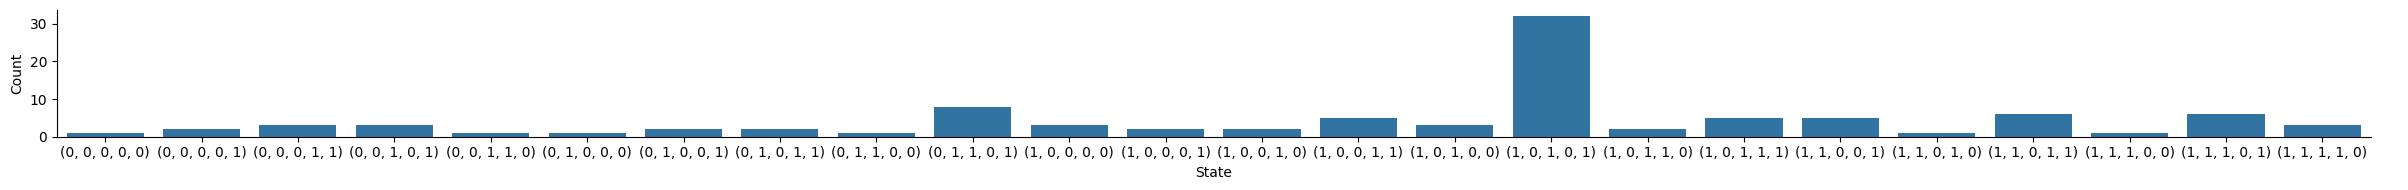

In [124]:
plot_counts(counts)

And compare our results to the noiseless emulation, we see that our emulator results match the noiseless simulation closely.

In [125]:
noiseless_handle = h_backend.process_circuit(
    circ_compiled, n_shots=n_shots, noisy_simulation=False
)
noiseless_result = h_backend.get_result(noiseless_handle)
noiseless_counts = noiseless_result.get_counts()

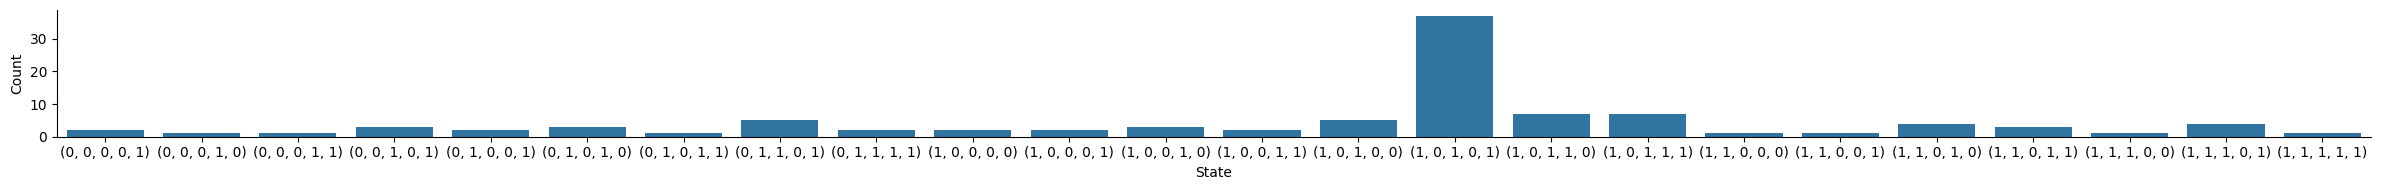

In [126]:
plot_counts(noiseless_counts)

One can also run the noiseless simulation using the Qiskit `Aer` simulator hosted in Quantinuum Nexus:

In [128]:
from pytket.extensions.nexus import AerConfig

# define a NexusBackend that targets the Aer simulator 
aer_backend = NexusBackend(
    backend_config=AerConfig(),
    project=hep_nexus_project,
)

With this new backend, we just need to follow the same steps we did before, but note that the simulation will run locally on your local CPU

In [129]:
# compile circuit as usual, but now for the new backend (the circ already has measurements)
compiled_circ = aer_backend.get_compiled_circuit(circ)

In [132]:
# submit and run the job: this runs locally and not in the cloud
# we can request many shots
handle = aer_backend.process_circuit(compiled_circ, n_shots=1024)

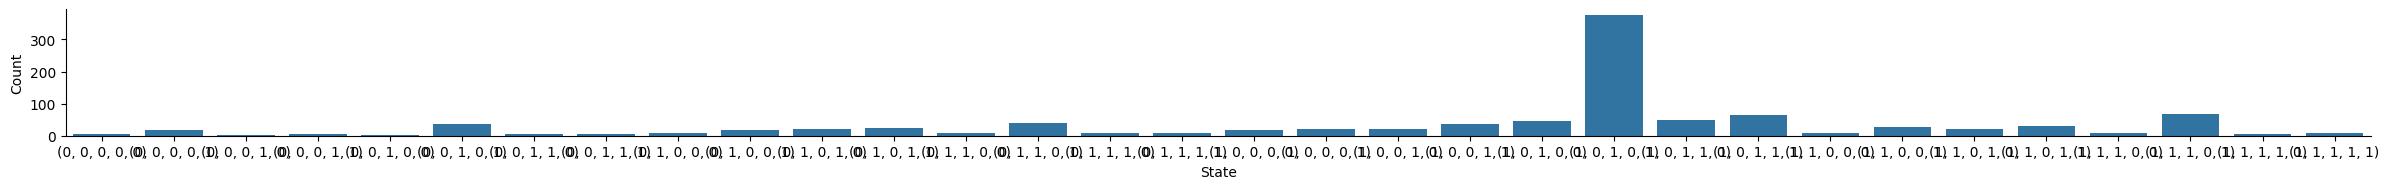

In [133]:
counts = aer_backend.get_result(handle).get_counts()
plot_counts(counts)

We can put together all that we have learned today and perform time evolution for many Trotter steps and measure the probability that an initial state _oscillates_ into a fixed target state

In [136]:
# we use this time line
print(time_line)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


Define symbolic Hamiltonian

In [139]:
from sympy import symbols

dt = symbols("dt")

In [142]:
hamiltonian_slice = hamiltonian_op * dt

Define the symbolic circuit for a single Trotter step

In [143]:
initial_state = Circuit(len(hamiltonian_slice.all_qubits))
trotter_step_circ = gen_term_sequence_circuit(hamiltonian_slice, initial_state)

In [144]:
trotter_step_circ.free_symbols()

{dt}

Encapsulate the circuit into a convenient `CircBox`

In [145]:
trotter_step_box = CircBox(trotter_step_circ)

For each time in the `time_line` we create the symbolic circuit and substitute the time step. We fix the number of Trotter steps so the cost of the circuit is the same at each iteration of the loop.

In [147]:
Nt = 2

In [148]:
# save Trotter step results
results = []

In [149]:
# final target state
final_state = (0, 0, 1, 0, 0)

In [151]:
from pytket.utils.distribution import ProbabilityDistribution

for final_time in time_line:
    # compute delta-t
    time_step = final_time / Nt
    # create symbol map
    dt_map = dict(zip([dt], [time_step]))
    # initial state: flip the third qubit
    circ = Circuit(len(hamiltonian_slice.all_qubits)).X(2)

    # circuit with Nt Trotter steps
    for _ in range(Nt):
        circ.add_gate(trotter_step_box, circ.qubits)

    # circuit to run on backend
    circ_run = circ.copy()
    # substitute current delta-t
    circ_run.symbol_substitution(dt_map)
    # run on Aer backend
    circ_compiled = aer_backend.get_compiled_circuit(circ_run.measure_all())
    # print some info about the circuit
    print(f"t={final_time:.2f} dt={time_step:.3f} n_2qb_gates={circ_compiled.n_2qb_gates()}")
    # submit circuit: skip the process and use run, since it is local
    result = aer_backend.run_circuit(circ_compiled, n_shots=8192)
    probabilities = result.get_empirical_distribution()
    # Construct probability distribution from the simulator results
    p = ProbabilityDistribution.from_empirical_distribution(probabilities)
    results.append(p[final_state])

t=0.00 dt=0.000 n_2qb_gates=0
t=0.10 dt=0.050 n_2qb_gates=56
t=0.20 dt=0.100 n_2qb_gates=56
t=0.30 dt=0.150 n_2qb_gates=56
t=0.40 dt=0.200 n_2qb_gates=56
t=0.50 dt=0.250 n_2qb_gates=56
t=0.60 dt=0.300 n_2qb_gates=56
t=0.70 dt=0.350 n_2qb_gates=56
t=0.80 dt=0.400 n_2qb_gates=56
t=0.90 dt=0.450 n_2qb_gates=56
t=1.00 dt=0.500 n_2qb_gates=52


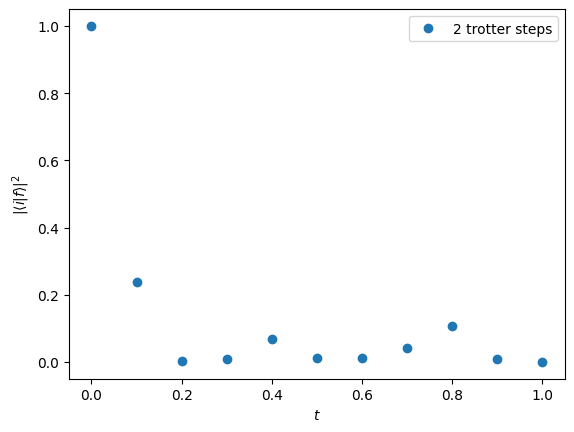

In [155]:
# plot the probability as a function of time
plt.figure()

plt.plot(time_line, results, 'o')
plt.xlabel(r"$t$")
plt.ylabel(r"$|\langle i \vert f \rangle|^2$")
plt.legend([f"{Nt} trotter steps"])

plt.show()

<div align="center"> &copy; 2024 by Quantinuum. All Rights Reserved. </div>